# Imports

In [ ]:
!pip install groq

# Libraries you might need
# General
import os
import zipfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# For pre-processing
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# For modeling
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchsummary

# For metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import  f1_score
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import confusion_matrix

import torchvision                                    # Used to work with image datasets and models in pytorch
from sklearn.datasets import load_iris # Iris dataset
# Allows for inline plots
%matplotlib inline
from sklearn.model_selection import train_test_split  # Splits the dataset into training and testing sets for model evaluation for tabular datasets
from sklearn.linear_model import LogisticRegression   # Imports LogisiticRegression class for classification tasks
from sklearn.tree import DecisionTreeClassifier       # Imports DecisionTreeClassifier class for classification tasks
from sklearn.neighbors import KNeighborsClassifier    # Imports KNeighBourClassifier class for classification based on similarity
from torch.utils.data import DataLoader               # Helps to load datasets and batch data - used for CIFAR-10 dataset

# Agent
from groq import Groq
from dataclasses import dataclass
import re
from typing import Dict, List, Optional


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
# Q1a (2 mark)
# Create a client using your API key.

client = None

client = Groq(api_key=os.environ.get("GROQ_API_KEY", " "))

In [ ]:
# Q1b (3 marks)

# instantiate chat_completion object using model of your choice (llama-3.3-70b-versatile - recommended)
# Hint: Use Tutorial 9 and Groq Documentation
# Explain each parameter and how each value change influences the LLM's output.
# Prompt the model using the user role about anything different from the tutorial.

chat_completion = None                        # Holds model's response

chat_completion = client.chat.completions.create(
    model = "llama-3.3-70b-versatile",        # The ID of LLM model - useful for complex tasks
    messages=[                                # A list of messages comprising the conversion
        {"role": "user",                      # A single user - represents message from human
         "content": "Explain the different types of Machine Learning Models." # The message
         }
    ],
    temperature=0.2,                          # Controls randomness - lower value for more precise and deterministic reponse
    top_p=0.7,                                # Selects from top percentage of likely samples - higher value ensures result is more random and diverse
    max_tokens=1024                           # Maximum number of tokens that can be generated in the chat completion - higher number means longer responses
)

chat_completion.choices[0].message.content    # The entire content/responses geerated by the model

'Machine learning models can be broadly classified into several types based on their learning style, functionality, and application. Here are the main types of machine learning models:\n\n**1. Supervised Learning Models:**\nThese models learn from labeled data, where the correct output is already known. The goal is to predict the output for new, unseen data. Examples include:\n\t* Regression models (e.g., linear regression, logistic regression)\n\t* Classification models (e.g., decision trees, random forests, support vector machines)\n\t* Neural networks (e.g., multilayer perceptrons, convolutional neural networks)\n\n**2. Unsupervised Learning Models:**\nThese models learn from unlabeled data, and the goal is to discover patterns, relationships, or groupings in the data. Examples include:\n\t* Clustering models (e.g., k-means, hierarchical clustering)\n\t* Dimensionality reduction models (e.g., principal component analysis, t-SNE)\n\t* Anomaly detection models (e.g., one-class SVM, lo

In [ ]:
# Q2a: (5 marks) Explain how agent implementation works, providing comments line by line.
# This paper might be helpful: https://react-lm.github.io/

@dataclass                                        # Generates special methods for the class such as  __init__
class Agent_State:                                # Holds the current state of agent's conversation
    messages: List[Dict[str, str]]                # List of dicts representing a message in conversation
    system_prompt: str                            # String that contains the instructions for the agent

class ML_Agent:               # Holds the core logic for interaction with LLM using the Thought/Action/Observation loop
    def __init__(self, system_prompt: str): # Initial context of information
        self.client = client                # Pre-configured API client
        self.state = Agent_State(           # Initializes the agent's state
            messages=[{"role": "system", "content": system_prompt}], #  Initial message with system prompt
            system_prompt=system_prompt,    #  Stores system prompt
        )

    def add_message(self, role: str, content: str) -> None: # Adds message to conversation history
        self.state.messages.append({"role": role, "content": content}) # Role = User, Content = Message text

    def execute(self) -> str:               # Sends the entire conversation history to LLM model API
        completion = self.client.chat.completions.create( #
            model="llama-3.3-70b-versatile",   # Specifies the LLM to use
            temperature=0.2,                   # Controls randomness - lower value = more deterministic responsed
            top_p=0.7,                         # Higher value ensures result is more random and diverse
            max_tokens=1024,                   # Maximum number of tokens that can be generated in the chat completion
            messages=self.state.messages,      # Passes the full conversation history
        )
        return completion.choices[0].message.content # Extracts the response from the API's outptut and returns it

    def __call__(self, message: str) -> str:  # Method that makes the agent instance callable
        self.add_message("user", message)     # Adds user's message to conversation history
        result = self.execute()               # Calls execute method and sends converation to LLM and gets reponse
        self.add_message("assistant", result) # Appends the returned response to conversation history
        return result                         # Returns the returned response

In [ ]:
# Q3a (3 marks): Implement model_memory tool.
# This tool should provide the agent with details about models or datasets
# Example: when asked about Penguin dataset, the agent can use memory to look up
# the source to obtain the dataset.

def model_memory(query: str) -> str:
    """
    Get the conversion rate for a given unit.

    Args:
        unit: The unit to get conversion rate for

    Returns:
        The conversion rate as a numerical value
    """
    model_datasets = {
        "Penguins": "Palmer Penguins dataset: includes bill length, depth, flipper length, and species. It can be found here: https://github.com/mwaskom/seaborn-data/blob/master/penguins.csv",
        "Iris": "Iris dataset: contains sepal and petal measurements for classification. It can be found here: https://gist.github.com/curran/a08a1080b88344b0c8a7",
        "CIFAR-10": "CIFAR-10: an image dataset with 10 classes for object recognition.",
        "Logistic Regression": "A linear classifier using the 'lbfgs' solver.",
        "Decision Tree": "A tree-based classifier with max_depth set to 3.",
        "KNN": "K-Nearest Neighbors classifier with 5 neighbors."
    }
    return model_datasets.get(query, f"No information available.")

In [ ]:
# Q3b (3 marks): Implement dataset_loader tool.
# loads dataset after obtaining info from memory

def dataset_loader(dataset_name: str):
    if dataset_name.lower() == "iris":
        data = load_iris(as_frame=True)  # If dataset passed is iris, loads it and returnes it
        return data.frame
    elif dataset_name.lower() == "penguins":
        df = sns.load_dataset("penguins")  # If dataset passed is penguins, loads it and returnes it
        return df
    elif dataset_name.lower() == "cifar-10":
        transform = transforms.Compose([transforms.ToTensor()]) # Converts images to tensors

        train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)                  # Loads training data and transforms to tensor
        trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)                        # Wraps training set as Dataloader

        test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)                  # Loads testing data and transforms to tensor
        testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)                        # Wraps training set as Dataloader

        return trainloader, testloader        # Returns the tuple containg the training and testing DataLoaders
    else:
        return None                           # If dataset does not match specified name, returns None
df_penguins = dataset_loader("penguins")
iris_df = dataset_loader("iris")
trainloader, testloader = dataset_loader("cifar-10")
print("Loaded all datasets.")

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Loaded all datasets.


In [ ]:
# Q3c (3 marks): Implement dataset_preprocessing tool.
# preprocesses the dataset to work with the chosen model, and does the splits

def dataset_preprocessing(data, target_column='target'):

    if hasattr(data, 'drop'):                  # For iris and pengiuns as they have a drop method for pandas dataframe
        X = data.drop(columns=[target_column]) # Drops the column specified in parameter
        y = data[target_column]                # Selects the target column and assigns to y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Splits the features (X) and labels (y) into training and testing sets
        return X_train, X_test, y_train, y_test # Returns the split data
    else:
        return data  # Assumes the data is already split (ex. CIFAR-10 tuple of loaders) from previous cell
X_train, X_test, y_train, y_test = dataset_preprocessing(iris_df, target_column="target")
print("Preprocessed.")

Preprocessed.


In [ ]:
# Q3d (3 points): Implement train_model tool.
# trains selected model on selected dataset, the agent should not use this tool
# on datasets and models that cannot work together.

TRAINED_MODEL = None      # Global variable to store the last trained model

# CNN model with dropout
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)  # For CIFAR-10 classification
        )

    def forward(self, x):
        x = self.conv1(x)   # Passes through first convolutional layer
        x = self.conv2(x)   # Passes through second convolutional layer
        x = self.fc(x)      # Passes the flattened result through fully connected layers
        return x            # Returns final output


#  CNN model with batch normalization
class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)  # For CIFAR-10 classification
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

# Assumes train_and_evaluate is a helper function that trains the CNN model - used from assignment 2

def train_and_evaluate(model, train_loader, valid_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)          # Moves the model to chosen device
    criterion = nn.CrossEntropyLoss() # Loss function for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

    for epoch in range(epochs):
        model.train()           # Sets modelto training mode
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False): # Use tqdm to show training of batches as it iterates in each epoch
            images, labels = images.to(device), labels.to(device) # Moves images to current device
            optimizer.zero_grad()  # Resets gradients
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels) # Commpute loss
            loss.backward()         # Backward pass
            optimizer.step()        # Updates model parameters
    return model

def train_model(model_name: str, data = None, X_train = None, y_train = None):

    model_name = model_name.lower().replace("_", " ") # Converts model passed to lower case and removes any underscores with spaces so agent can match it properly

    if X_train is None or y_train is None:    # For tabular datasets, if X_train or y_train not
       X_train = globals().get("X_train")     # provided get them from global variables
       y_train = globals().get("y_train")
       if X_train is None or y_train is None:
           raise ValueError("Training data not available.")

    if ("dropout" in model_name or "batchnorm" in model_name) and data is None: # For CNNs, if
        data = globals().get("trainloader"), globals().get("testloader") # data is not provided get them from the DataLoader global variables
        if None in data:
            raise ValueError("CIFAR-10 DataLoaders not available.")


# Selects and trains the model based on the parameter passed

    if "logistic regression" in model_name :
        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train, y_train)
    elif "decision tree" in model_name:
        model = DecisionTreeClassifier(max_depth=3)
        model.fit(X_train, y_train)
    elif "knn" in model_name:
        model = KNeighborsClassifier(n_neighbors=5)
        model.fit(X_train, y_train)
    elif "dropout" in model_name:
        train_loader, valid_loader = data
        model = CNN_Dropout()
        model = train_and_evaluate(model, train_loader, valid_loader, epochs=10)
    elif  "batchnorm" in model_name:
        train_loader, valid_loader = data
        model = CNN_BatchNorm()
        model = train_and_evaluate(model, train_loader, valid_loader, epochs=10)
    else:
        return "The model is not applicable for the given dataset."

    # Saves the trained model globally so that it can be used later
    global TRAINED_MODEL
    TRAINED_MODEL = model

    return model


In [ ]:
# Q3e (3 marks): Implement evaluate_model tool
# evaluates the models and shows the quality metrics (accuracy, precision, and anything else of your choice)

def evaluate_model(model, X_test = None, y_test= None):

    # If the model is provided as a string, replaces it with the actual trained model
    if isinstance(model, str):
        global TRAINED_MODEL
        if TRAINED_MODEL is None:
            raise ValueError("No trained model is available.")
        model = TRAINED_MODEL  # Sets the actual trained model

    if hasattr(model, "conv1"): # Checks if the model has a 'conv1' attribute - true for CNNs
        X_test = globals().get("testloader") # Retrieves the global test data loader
        if X_test is None:
            raise ValueError("No test data provided and global testloader is not set.")
        y_test = None
    else:
        if X_test is None or y_test is None: # For tabular data, gets globals if X_test and y_test not provided explicitly
            if globals().get("X_test") is not None and globals().get("y_test") is not None:
                X_test = globals()["X_test"]
                y_test = globals()["y_test"]
            else:
                raise ValueError("Test data not provided and not found in global scope.")

    if isinstance(X_test, DataLoader): # If X_test is a DataLoader, assumes evaluating a CNN model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()          # Sets model to eval mode
        y_true = []           # Initialize list of true labels
        y_pred = []           # Initialize list of predicted labels
        with torch.no_grad():
            for images, labels in X_test:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        metrics = {           # Computes metrics
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
            "recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
            "f1_score": f1_score(y_true, y_pred, average='weighted', zero_division=0)
        }
    else:
        # For tabular datasets
        y_pred = model.predict(X_test)
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
            "recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
            "f1_score": f1_score(y_test, y_pred, average='weighted', zero_division=0)
        }

    print("Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.2f}")

    return metrics


In [ ]:
# Q3f (5 marks): Implement visualize_results tool
# provides results of the training/evaluation, open-ended task (2 plots minimum)

def visualize_results(model, X_test=None, y_test=None):

    global TRAINED_MODEL
    if TRAINED_MODEL is None:
        raise ValueError("No trained model is available.")
    model = TRAINED_MODEL  # Replaces the model argument with global trained model

    # If no test data provided, retrieves it from global testloader - for CNN models
    if X_test is None:
        X_test = globals().get("testloader")
        if X_test is None:
            raise ValueError("No test data provided and global testloader is not set.")
        y_test = None  # For CNN models, y_test is not used

    if isinstance(X_test, DataLoader): # If X_test is a DataLoader, assumes evaluating a CNN model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in X_test:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        cm = confusion_matrix(y_true, y_pred)
        tick_marks = range(len(set(y_true))) # Helps to see the number of positions along each axis in confusion matrix
    else:
        y_pred = model.predict(X_test)        # For tabular datasets
        cm = confusion_matrix(y_test, y_pred) # Computes confusion matrix for true and predicted labels
        tick_marks = range(len(set(y_test)))  # Determines tick marks based on y_true

    # ---------------- Plot 1: Confusion Matrix  ----------------

    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center", color="red")
    plt.show()
    metrics = evaluate_model(model, X_test, y_test)  # Get evaluation metrics

    # ---------------- Plot 2: Bar Chart  ----------------
    plt.figure(figsize=(6,4))
    plt.bar(list(metrics.keys()), list(metrics.values()))
    plt.title("Evaluation Metrics")
    plt.ylim(0, 1)
    plt.show()

    return "Visualization Complete"

In [ ]:
# Q4a (10 marks) Build a system prompt to guide the agent based on Tutorial 9.
# Use the following function:

# Try to find alternative wording to keep the agent in the desired loop,
# don't just copy the prompt from the tutorial.

# Penalty for direct copy - 2 marks

def create_agent():
    # your system prompt goes inside the multiline string
     system_prompt = """
      - You are an intelligent ML evaluation assistant designed to interact using a Thought/Action/Observation loop.
      - Your role is to answer the prompt and exectute the necessary actions to answer it properly. For example, if it mentions to evaluate it, you have to provide the metrics for accuracy, precision, recall and F1-score.
      - Also, only if the prompt specifically asks to visualize results, you have to display the confusion matrix and bar plots, all inline, based on the functions that were executed previously.
      - Only output what the prompt asks to to do. If the prompt does not asks you to evaluate after training, do not evaluate it.
        - For example, if the prompt only asks you to preprocess the dataset and nothing further, do not train or evalaute it, just stop right after preprocessing it.
      - You need to train the model first using the provided function to execute the metrics. Before training, you need to preprocess it the dataset given in the prompt.
      - Also, when the prompt mentions to preprocess the data, remove any missing values and split the data into training and test.
      - Once the model evaluation is complete, immediately output an action to visualize the results, and plot the confusion matrix and box plots as per the function provided.
      -  Only if the prompt explicitly asks to visualize results, output exactly one additional action in the format:
         Action: visualize_results: <model_reference>
         so that the confusion matrix and bar plots are displayed.
         Do not output any visualization actions if the prompt does not request them.
      - Also, do not use any other model or dataset other than the one mentioned in the prompt.
      - You can access the following tools: model_memory, dataset_loader, dataset_preprocessing, train_model, evaluate_model, and visualize_results.
      - Always provide clear, step-by-step reasoning and ensure that your actions match the available tools.
      When you output an action, use the format: Action: <tool_name>: <input>.
      - After reasoning, output only one final action in the format: Action: <tool_name>: <input> and do not repeat actions in subsequent lines.
      - When training a model, output the action as Action: train_model: decision tree (with spaces, no additional text) so that the corresponding function is called.
      - After training and evaluating the model and prompt specifically asks to visualize results, then only output exactly one action to visualize the results using the format Action: visualize_results: <model_reference>. Do not output any additional visualization actions.

      """.strip()
     return ML_Agent(system_prompt)


In [ ]:
# Q5a: (2 marks) Explain why we need the following data structure and fill it in with appropriate values:

# This data structure serves as a mapping between the names and the function that implement those actions. It lets the agent dynamically call the appropriate function based on the action specified in the prompt. Each key corresponds to a specific tool.

KNOWN_ACTIONS = {  # Maps each action with their respective function
   # HINT See Tutorial 9.
    "model_memory": model_memory,
    "dataset_loader": dataset_loader,
    "dataset_preprocessing": dataset_preprocessing,
    "train_model": lambda input_str: train_model(input_str.strip(), X_train=X_train, y_train=y_train),
    "evaluate_model": lambda input_str: evaluate_model(TRAINED_MODEL, X_test, y_test),
    "visualize_results": lambda input_str: visualize_results(TRAINED_MODEL)
}


In [ ]:
# Q5b: (6 marks) Explain how the agent automation loop works line by line. Why do we need the ACTION_PATTERN variable?
# This paper might be helpful: https://react-lm.github.io/

# The ACTION_PATTERN variable is used to extarct the action from prompt and its output from agent. It ensures that the output follows a specific format so the appropriate action is called from the KNOWN_ACTIONS mapping. Without this, the loop would not know which lines in the agent's response represent the action.
ACTION_PATTERN = re.compile("^Action: (\w+): (.*)$") # Matches starting with 'Action' followed by space, colon and then any characters as action input

number_of_steps = 5 # Sets the maximum number of iterations to execute to prevent infinite loop

def query(question: str, max_turns: int = number_of_steps) -> List[Dict[str, str]]: # Takes user's question as input and returns the converastion history - used for Thought/Action/Observation loop
    agent = create_agent()          # Calls function to create a new instance with instructions from processing query
    next_prompt = question          # Holds the current prompt to send to agent at each iteration

    for turn in range(max_turns):   # Iterates through multiple rounds of thought and action
        result = agent(next_prompt) # Calls agent with prompt and gets response
        print(result)               # Prints agent's response
        actions = [                 # Splits response to lines
            ACTION_PATTERN.match(a) # Only lines that match the specific format are kept
            for a in result.split("\n") # Iteartes through agent's response
            if ACTION_PATTERN.match(a)  # Only lines that match the specific format are kept
        ]
        if actions:                   # Checks for valid actions
            action, action_input = actions[0].groups() # Takes the action and extract to 2 groups so that it can be used to look up and execute the correct function in KNOWN_ACTIONS
            if action not in KNOWN_ACTIONS: # If extracted action present, throws error
                raise ValueError(f"Unknown action: {action}: {action_input}") # Error raised
            print(f"\n ---> Executing {action} with input: {action_input}") # Prints message to show which action is being executed
            observation = KNOWN_ACTIONS[action](action_input) # Executes the correct tool for given action and stores it in a variable
            print(f"Observation: {observation}")  # Prints the observation about the result of action
            next_prompt = f"Observation: {observation}" # Updates the next_prompt with the observation so that the agent has context of the previous action - for Thought/Action/Observation loop
        else:
            break         # If no action lines are found, loop breaks and ends automation
    return agent.state.messages # After loop ends, returns the complete coversation history


In [ ]:
# Q5b: (2 marks)
# QUESTION: How can we check the whole history of the agent's interaction with LLM?

# The entire convesation hsitory is stored in the agent's state. The list is stored in 'agent.state.messages' which contains all the messages from the user, agent and system.
# For example, it stores the interaction between the agent and user such as, the system instructions, messages from user, and responses from agent.




 ******************************** Example 1: Train a logistic regression model on the Iris dataset
To train a logistic regression model on the Iris dataset, we first need to load the dataset and then preprocess it by removing any missing values and splitting it into training and test sets.

The Iris dataset is a classic multiclass classification problem, where we have 50 samples from each of three species of Iris flowers (Iris setosa, Iris versicolor, and Iris virginica). Each sample is described by 4 features: the length and width of the sepals and petals.

Here's how we can proceed:

1. Load the Iris dataset using the dataset_loader tool.
2. Preprocess the dataset by removing any missing values and splitting it into training and test sets using the dataset_preprocessing tool.
3. Train a logistic regression model on the preprocessed training data using the train_model tool.

Action: dataset_preprocessing: Iris dataset
Action: train_model: logistic regression

 ---> Executing dataset_

Observation: CNN_Dropout(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
The dropout CNN model has been trained. 

Next, we need to evaluate the model's performance. We will use the evaluate_model tool to calculate metrics such as accuracy, precision, recall, and F1-score.

Action: evaluate_model: dropout CNN

 --->

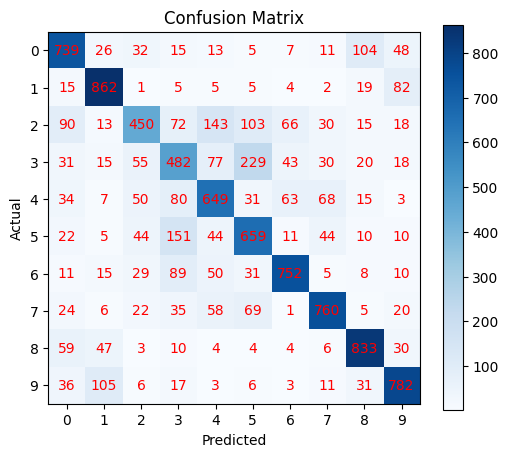

Evaluation Metrics:
Accuracy: 0.70
Precision: 0.70
Recall: 0.70
F1_score: 0.69


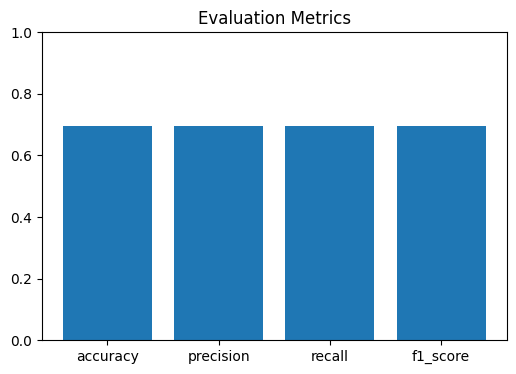

Observation: Visualization Complete




In [ ]:
# Execute any THREE example prompts using your agent. (Each working prompt exaple will give you 5 marks, 5x3=15)
# DONT FORGET TO SAVE THE OUTPUT

# User Prompt examples you should be able to give to your agent:
# **Evaluate Linear Regression Model on Iris Dataset**
# **Train a logistic regression model on the Iris dataset**
# **Load the Penguins dataset and preprocess it.**
# **Train a decision tree model on the Penguins dataset and evaluate it.**
# **Load the CIFAR-10 dataset and train Mini-ResNet CNN, visualize results**

# Use this template:

# # Example 1: Prompt
# print("\nExample 1: Evaluate Linear Regression Model on Iris Dataset")
# print("=" * 50)
# task = "Evaluate Linear Regression Model on Iris Dataset"
# result = query(task)
# print("\n" + "=" * 50 + "\n")

# Example 1: Train a logistic regression model on the Iris dataset.
print("\n ******************************** Example 1: Train a logistic regression model on the Iris dataset")
print("=" * 50)
task2 = "Train a logistic regression model on the Iris dataset."
result2 = query(task2)
print("\n" + "=" * 50 + "\n")

# Example 2: Load the Penguins dataset and preprocess it.
print("\n ******************************** Example 2: Load the Penguins dataset and preprocess it.")
print("=" * 50)
task3 = "Load the Penguins dataset and preprocess it."
result3 = query(task3)

# Example 3: Train a decision tree model on the Penguins dataset and evaluate it
print("\n ******************************** Example 3: Train a decision tree model on the Penguins dataset and evaluate it.")
print("=" * 50)
task = "Train a decision tree model on the Penguins dataset and evaluate it."
result = query(task)
print("\n" + "=" * 50 + "\n")

# # Example 4: Loads the Penguins dataset and preprocess it.
print("\n ******************************** Example 4: Load the CIFAR-10 dataset and train dropout CNN, visualize results")
print("=" * 50)
task = " Load the CIFAR-10 dataset and train dropout CNN, visualize result"
result = query(task)
print("\n" + "=" * 50 + "\n")



In [2]:
!pip install watermark
# Provide your Signature:
%load_ext watermark
%watermark -a 'Nikita V' -nmv --packages numpy,pandas,sklearn,matplotlib,seaborn,graphviz,groq,torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.3 MB/s eta 0:00:00
Author: Nikita V

Python implementation: CPython
Python version       : 3.11.12
IPython version      : 7.34.0

numpy     : 2.0.2
pandas    : 2.2.2
sklearn   : 1.6.1
matplotlib: 3.10.0
seaborn   : 0.13.2
graphviz  : 0.20.3
groq      : not installed
torch     : 2.6.0+cu124

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.123+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

